In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg, mean, dot
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split


In [387]:
with open("../collect-data/src/files/nba_data.xlsx", "rb") as file:
    nba_stats_df = pd.read_excel(file, sheet_name="NBA Stats")
    mvp_df = pd.read_excel(file, sheet_name="MVP")

In [388]:
mvp_df["MVP?"] = 1
nba_stats_df["MVP?"] = 0

mvp_dict = mvp_df.to_dict("index")
nba_stats_dict = nba_stats_df.to_dict("index")

for k in mvp_dict:
    id = mvp_dict[k]["Unnamed: 0"]
    nba_stats_dict[id]["MVP?"] = 1

nba_stats_df = pd.DataFrame.from_dict(nba_stats_dict, orient="index")
# nba_stats_df = nba_stats_df[nba_stats_df["RANK"] < 60]
nba_stats_df = nba_stats_df[nba_stats_df["GP"] >= 53]
nba_stats_df = nba_stats_df[nba_stats_df["MIN"] >= 1060]
print(nba_stats_df["MVP?"].value_counts())



MVP?
0    6195
1      26
Name: count, dtype: int64


In [389]:
nba_stats_df.head()

,Unnamed: 0,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,MVP?
0,0,1,Luka,Doncic,NaN,DAL,25,63,40,23.0,...,249,93,34,131,3881,43,19,222,2023-24,0
1,1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,70,50,20.0,...,154,147,64,175,3746,8,0,553,2023-24,0
2,2,3,Giannis,Antetokounmpo,NaN,MIL,29,68,43,25.0,...,234,81,69,199,3892,54,9,314,2023-24,0
3,3,4,Jayson,Tatum,NaN,BOS,26,68,53,15.0,...,173,70,40,136,3190,24,0,599,2023-24,0
4,4,5,Jalen,Brunson,NaN,NYK,27,67,43,24.0,...,161,61,13,125,2839,5,0,408,2023-24,0


In [390]:
nba_stats_df.columns

Index(['Unnamed: 0', 'RANK', 'FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM',
       'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'SEASON', 'MVP?'],
      dtype='object')

In [391]:
nba_stats_df = nba_stats_df[['AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'PF', 'FP', 'DD2', 'TD3', 'MVP?']]

nba_stats_df.corr()

,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,MVP?
AGE,1.000000,-0.024438,0.216787,0.078527,-0.007693,-0.072043,-0.073752,-0.079422,-0.062133,0.037477,...,-0.035093,0.060465,-0.086579,-0.022832,-0.056546,0.011397,-0.045570,-0.030786,0.154410,0.005246
GP,-0.024438,1.000000,0.436557,0.052866,0.494782,0.244028,0.255050,0.258985,0.032532,0.047566,...,0.252044,0.148367,0.261192,0.277404,0.142320,0.384745,0.306621,0.109550,-0.023755,0.035577
W,0.216787,0.436557,1.000000,-0.241095,0.240337,0.174159,0.170862,0.134050,0.143216,0.118473,...,0.144200,0.137665,0.088261,0.179692,0.101959,0.126095,0.222379,0.101244,0.016185,0.111403
L,0.078527,0.052866,-0.241095,1.000000,0.013300,-0.015446,0.032629,-0.010233,-0.140294,-0.041601,...,-0.000326,-0.017688,0.029746,0.010433,0.071861,0.556746,-0.034061,-0.017085,0.881231,-0.029736
MIN,-0.007693,0.494782,0.240337,0.013300,1.000000,0.811879,0.814596,0.826170,0.045181,0.322139,...,0.487308,0.549356,0.733369,0.639954,0.216925,0.407628,0.855989,0.475228,0.040632,0.096830
PTS,-0.072043,0.244028,0.174159,-0.015446,0.811879,1.000000,0.982634,0.974940,0.105759,0.433781,...,0.411768,0.540871,0.789606,0.521803,0.153886,0.257701,0.909585,0.514172,0.076906,0.186217
FGM,-0.073752,0.255050,0.170862,0.032629,0.814596,0.982634,1.000000,0.971164,0.172309,0.343554,...,0.472337,0.509273,0.775101,0.504226,0.209565,0.311793,0.915487,0.557543,0.117973,0.179542
FGA,-0.079422,0.258985,0.134050,-0.010233,0.826170,0.974940,0.971164,1.000000,-0.029525,0.451113,...,0.355044,0.557913,0.786833,0.548108,0.097050,0.238728,0.876814,0.456852,0.057988,0.155127
FG%,-0.062133,0.032532,0.143216,-0.140294,0.045181,0.105759,0.172309,-0.029525,1.000000,-0.383864,...,0.518829,-0.157078,0.022882,-0.124089,0.460494,0.170297,0.239252,0.393237,-0.080058,0.057268
3PM,0.037477,0.047566,0.118473,-0.041601,0.322139,0.433781,0.343554,0.451113,-0.383864,1.000000,...,-0.271697,0.347547,0.201103,0.277503,-0.335656,-0.164991,0.238701,-0.164780,0.019553,0.050712


In [392]:
stats_df = nba_stats_df[['AGE', 'L', 'PTS', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TD3', 'MVP?']]
stats_df.corr()
# High correlation: TOV, W, FTM, FTA, FP, PF, 3PM, 3PA, DD2, FGM, FGA, OREB, DREB, MIN, GP

,AGE,L,PTS,FG%,3P%,FT%,REB,AST,STL,BLK,TD3,MVP?
AGE,1.000000,0.078527,-0.072043,-0.062133,0.054808,0.123603,-0.035093,0.060465,-0.022832,-0.056546,0.154410,0.005246
L,0.078527,1.000000,-0.015446,-0.140294,0.186433,0.099814,-0.000326,-0.017688,0.010433,0.071861,0.881231,-0.029736
PTS,-0.072043,-0.015446,1.000000,0.105759,0.178965,0.307546,0.411768,0.540871,0.521803,0.153886,0.076906,0.186217
FG%,-0.062133,-0.140294,0.105759,1.000000,-0.393747,-0.354999,0.518829,-0.157078,-0.124089,0.460494,-0.080058,0.057268
3P%,0.054808,0.186433,0.178965,-0.393747,1.000000,0.479166,-0.370763,0.257857,0.186060,-0.372827,0.220253,0.011990
FT%,0.123603,0.099814,0.307546,-0.354999,0.479166,1.000000,-0.307645,0.294954,0.135646,-0.369144,0.114726,0.031336
REB,-0.035093,-0.000326,0.411768,0.518829,-0.370763,-0.307645,1.000000,-0.024969,0.150430,0.684354,0.064907,0.106712
AST,0.060465,-0.017688,0.540871,-0.157078,0.257857,0.294954,-0.024969,1.000000,0.614891,-0.203450,0.129162,0.134583
STL,-0.022832,0.010433,0.521803,-0.124089,0.186060,0.135646,0.150430,0.614891,1.000000,-0.023644,0.080143,0.089671
BLK,-0.056546,0.071861,0.153886,0.460494,-0.372827,-0.369144,0.684354,-0.203450,-0.023644,1.000000,0.082179,0.060623


Text(0, 0.5, 'STL')

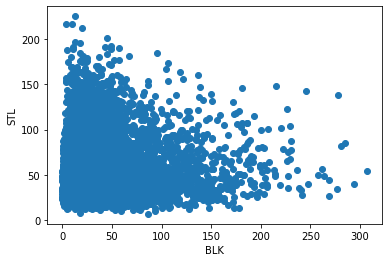

In [393]:
# GP and MIN have a very high correlation. Why would the NBA require these stats to be apart of the criteria to receive a post-season award? Perhaps they are to be used only as filters to condense the dataset.
plt.scatter(stats_df.BLK, stats_df.STL)
plt.xlabel("BLK")
plt.ylabel("STL")

In [394]:
stats_df.var()

AGE         18.064464
L         1314.486914
PTS     176735.778545
FG%         30.938923
3P%        225.639770
FT%         90.408382
REB      35205.989950
AST      21025.733248
STL        948.365752
BLK       1577.792389
TD3         18.716539
MVP?         0.004163
dtype: float64

In [395]:
stats_df.cov()

,AGE,L,PTS,FG%,3P%,FT%,REB,AST,STL,BLK,TD3,MVP?
AGE,18.064464,12.100722,-128.725809,-1.468890,3.499188,4.995119,-27.986341,37.264197,-2.988405,-9.546417,2.839238,0.001439
L,12.100722,1314.486914,-235.424015,-28.292463,101.533627,34.409271,-2.220830,-92.991510,11.648929,103.489634,138.223101,-0.069556
PTS,-128.725809,-235.424015,176735.778545,247.305716,1130.157643,1229.351839,32480.542282,32970.961259,6755.483302,2569.716012,139.873277,5.050834
FG%,-1.468890,-28.292463,247.305716,30.938923,-32.898635,-18.775177,541.483403,-126.690367,-21.255598,101.742191,-1.926510,0.020552
3P%,3.499188,101.533627,1130.157643,-32.898635,225.639770,68.438179,-1044.991039,561.644579,86.069174,-222.454206,14.313382,0.011620
FT%,4.995119,34.409271,1229.351839,-18.775177,68.438179,90.408382,-548.862040,406.662389,39.718964,-139.419940,4.719331,0.019223
REB,-27.986341,-2.220830,32480.542282,541.483403,-1044.991039,-548.862040,35205.989950,-679.329383,869.224004,5100.513920,52.688464,1.291822
AST,37.264197,-92.991510,32970.961259,-126.690367,561.644579,406.662389,-679.329383,21025.733248,2745.754949,-1171.813586,81.025473,1.259060
STL,-2.988405,11.648929,6755.483302,-21.255598,86.069174,39.718964,869.224004,2745.754949,948.365752,-28.922415,10.677464,0.178164
BLK,-9.546417,103.489634,2569.716012,101.742191,-222.454206,-139.419940,5100.513920,-1171.813586,-28.922415,1577.792389,14.122105,0.155362


In [396]:
num_components = 2
cov = stats_df.cov().to_numpy()
A = stats_df.to_numpy()
[eigvals, pcs] = linalg.eig(cov)

sorted_index = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_index]
pcs = pcs[:,sorted_index]

M = (A - mean(A.T, axis=1)).T
projected = dot(pcs.T, M).T
projected = pd.DataFrame(projected[:,:num_components], columns=["pc1", "pc2"])
projected

,pc1,pc2
0,-1348.995130,113.643640
1,-1277.313796,202.038657
2,-1308.827347,-157.476683
3,-1025.122300,-20.872484
4,-956.180357,305.284135
...,...,...
6216,568.059416,-28.598335
6217,562.223338,-131.790347
6218,428.876795,-545.848335
6219,575.569452,-72.342560


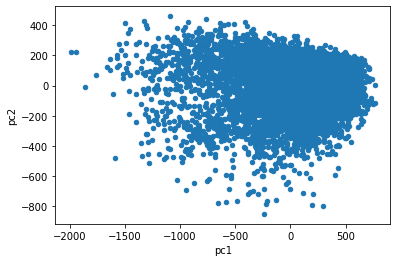

In [397]:
projected.plot(kind="scatter", x="pc1", y="pc2")

In [403]:
# Decision Tree
Y = stats_df["MVP?"]
X = stats_df.drop("MVP?", axis=1)
max_depths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.8, random_state=1)
for depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_Train, Y_Train)
    Y_predTest = clf.predict(X_Test)
    Y_predTrain = clf.predict(X_Train)
    print("depth:", depth, "test accuracy:", accuracy_score(Y_Test, Y_predTest), "train accuracy:", accuracy_score(Y_Train, Y_predTrain))

4977


In [399]:
f1 = f1_score(Y_Test, Y_predTest, labels=["0", "1"], pos_label=1)
print(f1)

0.44
